In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision 
from torchvision import transforms

In [2]:
torch.__version__

'1.7.1'

# 数据准备

In [3]:
#对数据做归一化（-1，1）
transform =transforms.Compose([
    transforms.ToTensor(),#O-1；channel，hish，witch，
    transforms.Normalize(0.5,0.5) # 归一化,均值和方差
])


In [4]:
train_ds=torchvision.datasets.MNIST('data',train=True,transform=transform,download=True)

In [5]:
dataloader = torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)

In [6]:
type(dataloader)

torch.utils.data.dataloader.DataLoader

In [7]:
imgs,_ = next(iter(dataloader))

In [8]:
type(imgs)

torch.Tensor

# 定义生成器

In [9]:
#输入是长度为100的噪声（正态分布随机数）
#输出为（1，28，28）的图片linear 1：100-—-256
'''
linear 2：256—-512
linear 2：512--28*28
reshape：28*28——（1,28，28)
'''

'\nlinear 2：256—-512\nlinear 2：512--28*28\nreshape：28*28——（1,28，28)\n'

In [10]:
class Generator(nn. Module): 
    def __init__(self): 
        super(Generator, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(100,256), 
            nn.ReLU(), 
            nn.Linear(256,512), 
            nn.ReLU(), 
            nn.Linear(512,28*28), 
            nn.Tanh()
        )
    def forward(self,x):  #x 表示长度为100 的 noise输入
        img = self.main(x)
        img = img.view(-1,28,28)
        return img
         

# 定义判别器

In [11]:
#输入为（1，28，28）的图片输出为二分类的概率值，输出使用signmoid激活0-1
#BCEloss计算交叉篇损失
#nn.LeakyRelU f（x）：x>0输出x，如果O，输出a*xa表示一个很小的斜率，比如0.1
#判别器中一般推荐使用 LeakyReLU 

In [12]:
class Discriminator(nn. Module): 
    def __init__(self): 
        super(Discriminator, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(28*28,512), 
            nn.LeakyReLU(), 
            nn.Linear(512,256), 
            nn.LeakyReLU(), 
            nn.Linear(256,1), 
            nn.Sigmoid()
        )
    def forward(self,x):  #x 表示长度为100 的 noise输入
        x = x.view(-1,28*28)
        x = self.main(x)
        return x
         

# 初始化模型、优化器以及损失计算函数

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
generator = Generator().to(device)

In [15]:
discriminator = Discriminator().to(device)

In [16]:
d_optim = torch.optim.Adam(discriminator.parameters(),lr=0.0001)
g_optim = torch.optim.Adam(generator.parameters(),lr=0.0001)

In [17]:
loss_fn = torch.nn.BCELoss()

# 绘图函数

In [18]:
def gen_img_plot(model,test_input):
    #np.squeeze 将维度为1的去掉
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig =  plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        #plt.imshow绘图要么是0-1之间的float，要么是0-255之间的uint
        plt.imshow((prediction[i]+1)/2,cmap='gray')
        plt.axis('off')
    plt.show()

In [19]:
test_input = torch.randn(16,100,device=device)

# GAN的训练

对判别器的损失包含两部分<br />
1、输入真实的图像到判别器中，得到对真实图像的判别结果，并与1计算他对应的损失<br />
2、得到生成的图像,将生成的图像输入到判别器中，得到生成图像的判别结果，并与0计算它对应的损失<br />
对生成器的损失只有一部分<br />
输入生成图像到判别器中，得到对生成图像的判别结果，由于是生成器希望判别结果为1，所以要与1计算它的损失<br />
注意由于是计算生成器的损失，所以生成的图片梯度不用截取

In [20]:
D_loss = []
G_loss = []

In [21]:
def train():
    # 训练循环
    for epoch in range(20):
        d_epoch_loss = 0
        g_epoch_loss = 0
        count = len(dataloader)
        # step是数据的位置，img是坐标，_无用是标签target
        for step, (img, _) in enumerate(dataloader):
            img = img.to(device)
            #查看有多少张图片
            size = img.size(0)
            random_noise = torch.randn(size, 100, device=device)
            '''对判别器的损失'''
            #在判别器上输入真实的数据计算它的损失 
            #梯度清零
            d_optim.zero_grad()
            #判别器输入真实的图片，real_output对真实图片的预测结果
            real_output = discriminator(img)  
            #得到判别器在真实图像上的损失
            d_real_loss = loss_fn(real_output,torch.ones_like(real_output))
            d_real_loss.backward()


            #在生成图像上计算判别器的损失
            #生成器生成图片
            gen_img = generator(random_noise)
            #判别器输入生成的图片，fake_output对生成图片的预测  .detach对梯度进行截断。截断的是生成器的梯度
            fake_output = discriminator(gen_img.detach())
            #得到判别器在生成图像的损失
            d_fake_loss = loss_fn(fake_output,torch.zeros_like(fake_output))
            d_fake_loss.backward()

            d_loss = d_real_loss + d_fake_loss
            d_optim.step()

            '''对生成器的损失，不用对生成图像进行截断'''
            #将生成器的梯度归零
            g_optim.zero_grad()
            fake_output = discriminator(gen_img)
            g_loss = loss_fn(fake_output,torch.ones_like(fake_output))
            g_loss.backward()
            g_optim.step()
            
            with torch.no_grad():
                d_epoch_loss += d_loss
                g_epoch_loss += g_loss
            
        with torch.no_grad():
            d_epoch_loss /= count
            g_epoch_loss /= count
            D_loss.append(d_epoch_loss)
            G_loss.append(g_epoch_loss)
            print("Epoch:",epoch)
            gen_img_plot(generator,test_input)
        

Epoch: 0


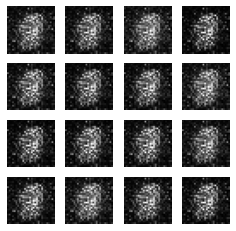

Epoch: 1


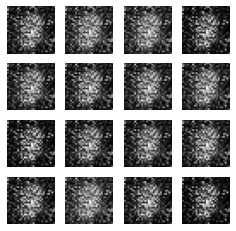

Epoch: 2


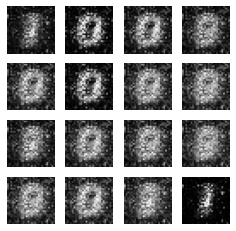

Epoch: 3


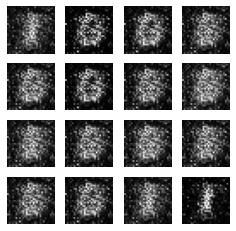

Epoch: 4


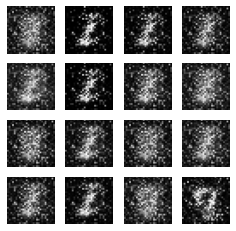

Epoch: 5


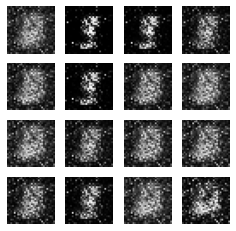

Epoch: 6


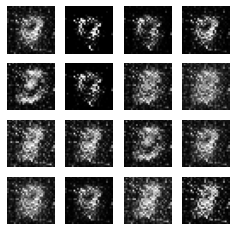

Epoch: 7


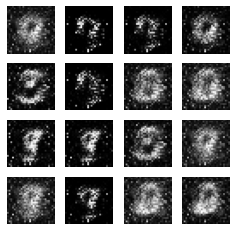

Epoch: 8


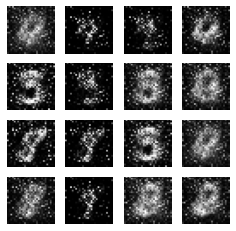

Epoch: 9


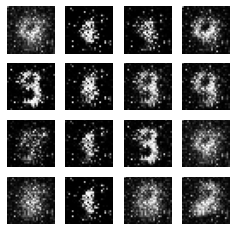

Epoch: 10


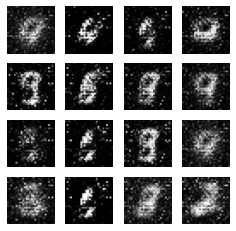

Epoch: 11


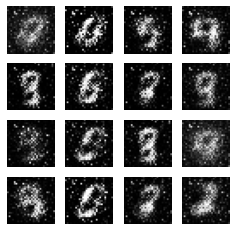

Epoch: 12


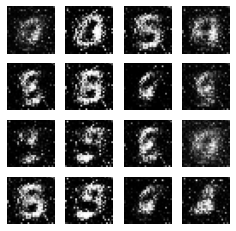

Epoch: 13


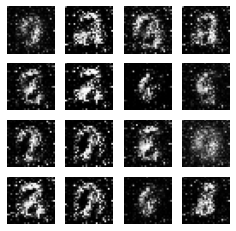

Epoch: 14


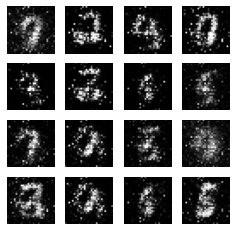

Epoch: 15


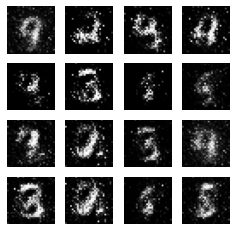

Epoch: 16


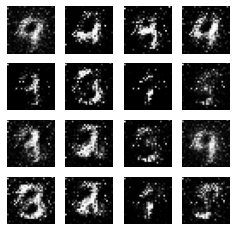

Epoch: 17


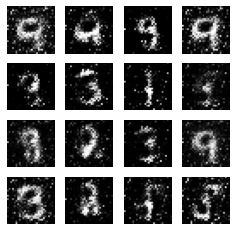

Epoch: 18


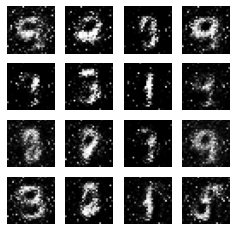

Epoch: 19


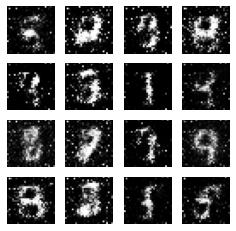

In [22]:
train()